In [1]:
from __future__ import print_function
%matplotlib notebook
import numpy as np, pylab as plt
import aipy, hera_sim, uvtools, hera_cal, linsolve
from pyuvdata import UVBeam, utils
import healpy
from scipy.interpolate import interp1d
from uvtools.dspec import linear_filter
import matplotlib.colors as colors

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Build Observations

Using a 1D array based on a Golomb ruler (https://en.wikipedia.org/wiki/Golomb_ruler).
Frequency coverage (60 to 220 MHz) reflects expanded HERA band.

## Observing Parameters

In [2]:
NFREQS = 1024
NPIX = 128
freqs = np.linspace(.06, .22, NFREQS) # GHz
jds = np.linspace(2458388.0, 2458388.2, 60)

### Antenna Array

In [3]:
#sep = 14.7 * 100 / aipy.const.len_ns
sep = 14.7 * 100 / aipy.const.len_ns / 50. # XXX important for long baselines, but unrealistically short?
#goloumb = [0, 2, 5, 25, 37, 43, 59, 70, 85, 89, 98, 99, 106]
goloumb = [0,3,15,41,66,95,97,106,142,152,220,221,225,242,295,330,338,354,382,388,402,415,486,504,523,546,553]
seps = {xi-xj: (j,i) for i,xi in enumerate(goloumb) for j,xj in enumerate(goloumb) if xi > xj}
antpos_dict = {i: np.array((x * sep, 0., 0.)) for i,x in enumerate(goloumb)}
#antpos_dict = hera_sim.antpos.linear_array(20, sep=sep)
antpos = np.array(antpos_dict.values())
NANTS = antpos.shape[0]
baselines = [(aj,ai) for ai in range(NANTS) for aj in range(ai+1,NANTS)]

<IPython.core.display.Javascript object>


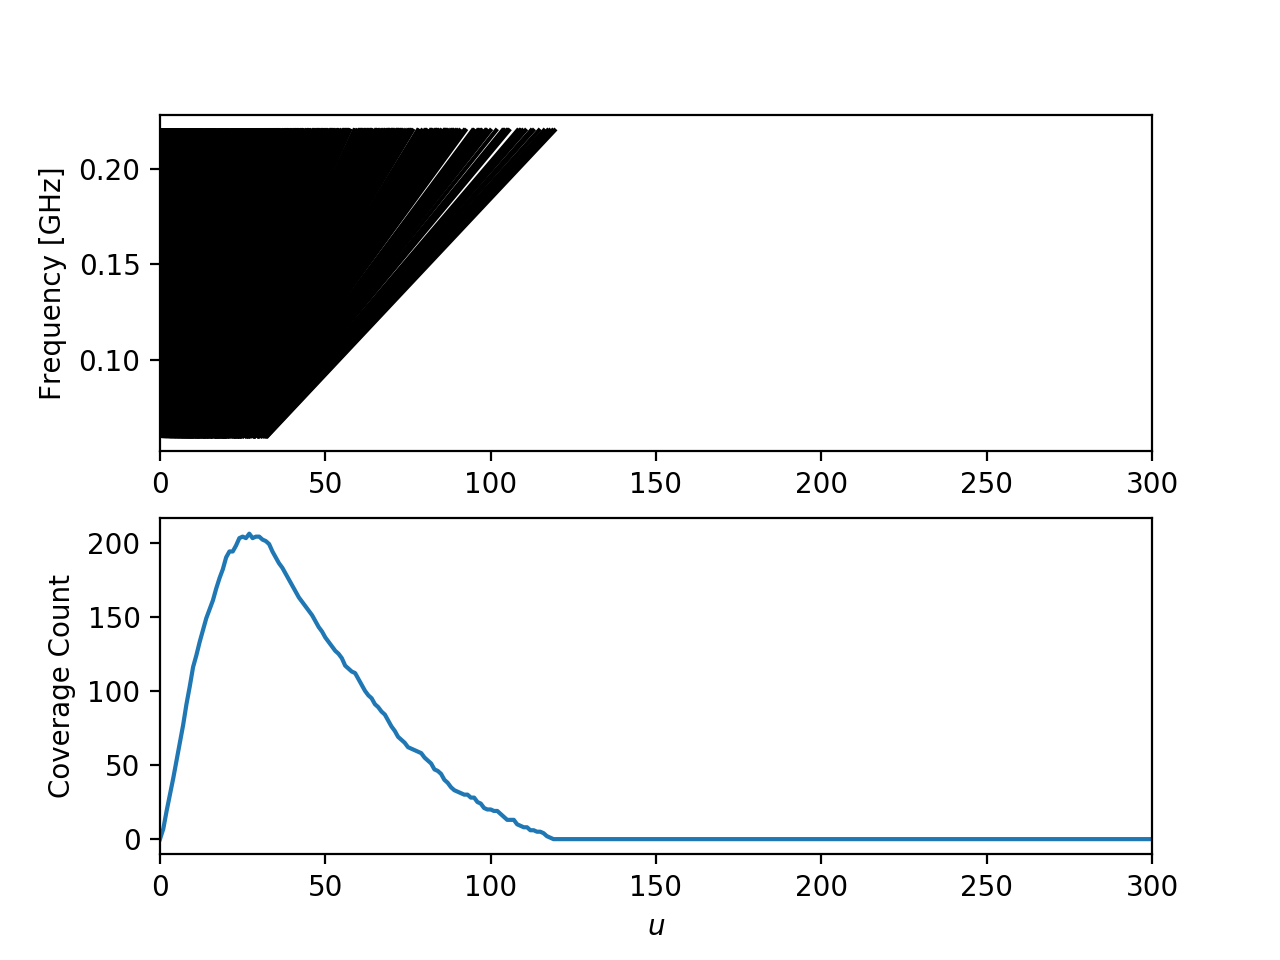

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(0, 300)

In [4]:
coverage_vs_u = np.zeros(2000)
plt.figure()
ax = plt.subplot(212)
plt.subplot(211, sharex=ax)
for s in seps.keys():
    umin,umax = s * sep * freqs[0], s * sep * freqs[-1]
    coverage_vs_u[int(np.ceil(umin)):int(np.floor(umax))] += 1
    plt.plot([umin, umax], [freqs[0], freqs[-1]], 'k')
plt.ylabel('Frequency [GHz]')
plt.subplot(212)
plt.plot(coverage_vs_u)
plt.xlabel('$u$')
plt.ylabel('Coverage Count')
plt.xlim(0, 300)

### Model Beam 

In [5]:
# Option 1: Make a simple Gaussian Beam
def beam_gaussian(xs, fqs, width=0.2, mfreq=0.15, chromatic=True):
    if np.shape(xs) == ():
        xs = np.array([xs])
    xs.shape = (xs.size,1)
    if np.shape(fqs) == ():
        fqs = np.array([fqs])
    fqs.shape = (1, fqs.size)
    if chromatic:
        width = width * mfreq / fqs
    else:
        width = width * np.ones_like(fqs)
    width.shape = (1,-1)
    resp = np.exp(-(xs**2) / (2 * np.sin(width)**2)).astype(np.float32)
    resp.shape = (xs.size, fqs.size)
    return resp

# Option 2: Sinc function
def beam_sinc(xs, fqs, width=0.2, mfreq=0.15, chromatic=True):
    if np.shape(xs) == ():
        xs = np.array([xs])
    xs.shape = (xs.size,1)
    if np.shape(fqs) == ():
        fqs = np.array([fqs])
    fqs.shape = (1, fqs.size)
    if chromatic:
        width = width * mfreq / fqs
    else:
        width = width * np.ones_like(fqs)
    width.shape = (1,-1)
    resp = np.sinc(xs / np.sin(width) / 2).astype(np.float32)
    resp.shape = (xs.size, fqs.size)
    return resp    

<IPython.core.display.Javascript object>


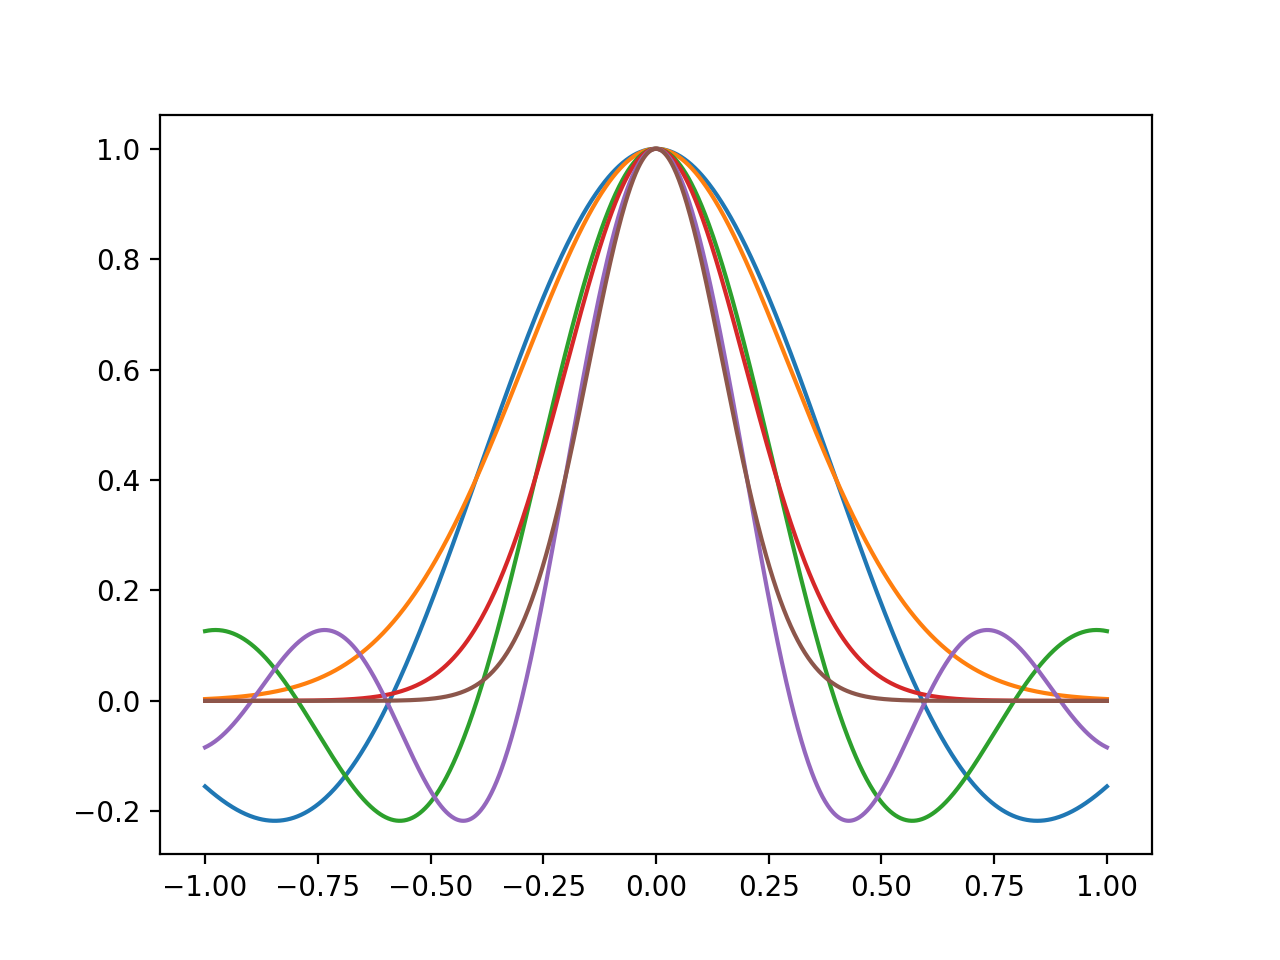

In [6]:
plt.figure()
xs = np.linspace(-1,1,1025,endpoint=True)
#for fq in np.linspace(.05,0.25,10):
for fq in [.1, .15, .2]:
    plt.plot(xs, beam_sinc(xs, fq))
    plt.plot(xs, beam_gaussian(xs, fq))
plt.show()

# Simulate Visibilities (compute intense)

Drawing each pixel of the sky from a uniform distribution, with its own spectral index.

In [7]:
fg_map = np.random.uniform(0, 10, size=(NPIX,1))
fg_ind = np.random.uniform(-2, -1, size=(NPIX,1))
Isky = {
    'F': fg_map * (freqs/0.15)**fg_ind,
    'f': fg_map * (0.150/0.15)**fg_ind,
}
xs = np.linspace(-1, 1, NPIX, endpoint=True)
dx = np.median(np.diff(xs))

In [8]:
Isky['E'] = np.random.uniform(0, .0001, size=(NPIX,NFREQS))

<IPython.core.display.Javascript object>


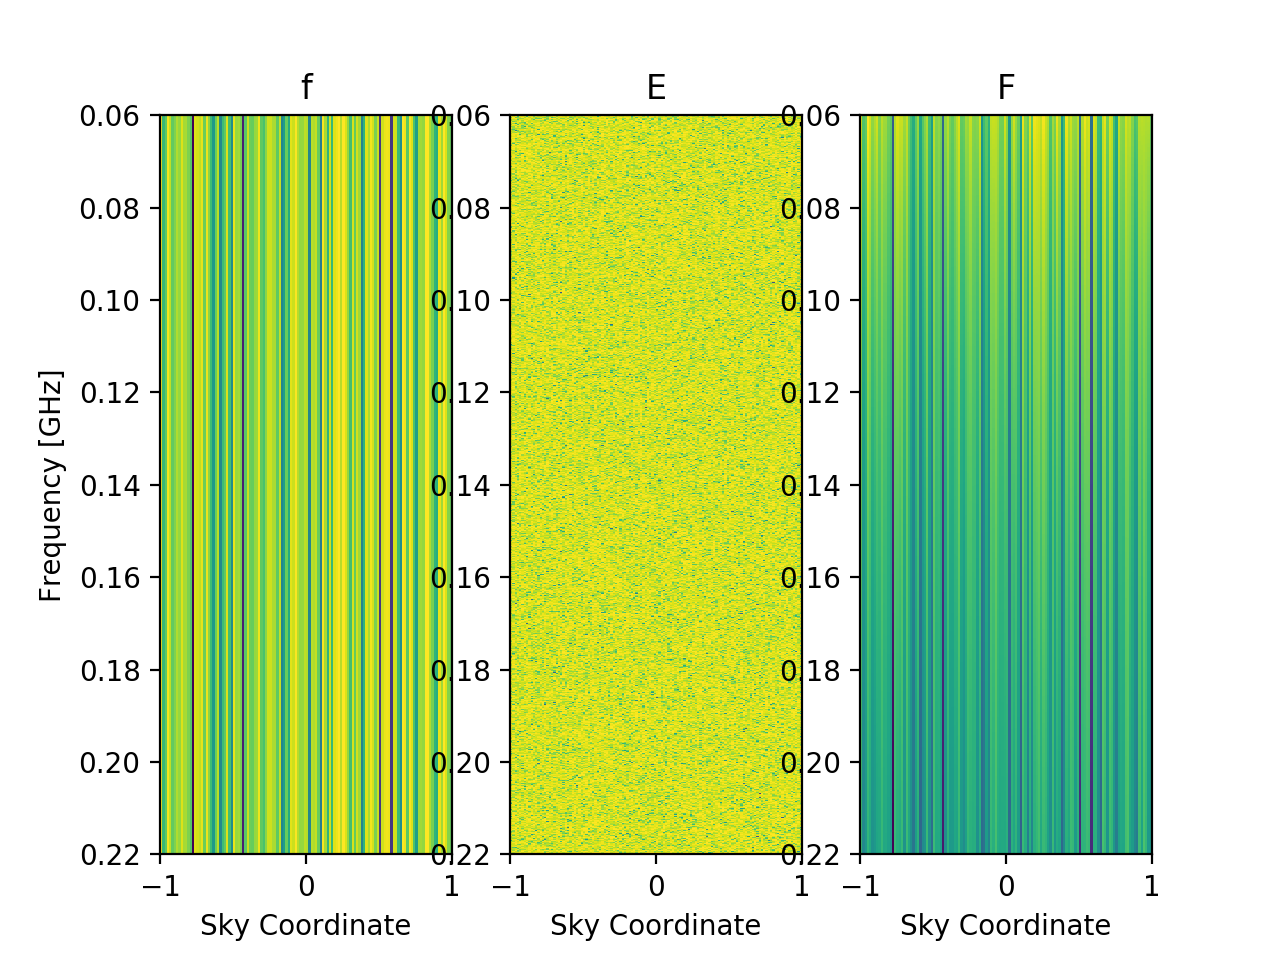

In [9]:
plt.figure()
freqs = freqs.flatten()
extent = (-1,1,freqs[-1],freqs[0])
for cnt,key in enumerate(Isky.keys()):
    plt.subplot(1, 3, cnt+1)
    plt.title(key)
    uvtools.plot.waterfall(Isky[key].T, extent=extent)
    if cnt == 0: plt.ylabel('Frequency [GHz]')
    plt.xlabel('Sky Coordinate')

### An Aside About Integrating Fringes

To accommodate a sparsely sampled sky, we need to be careful about aliasing our fringe. Each sample of the fringe should be regarded as the integral of the fringe function over the width of the sky pixel.
\begin{equation}
f(x_0) = \frac{1}{\Delta x}\int_{x_0-\Delta x/2}^{x_0+\Delta x/2}{f(x) dx}
\end{equation}

<IPython.core.display.Javascript object>


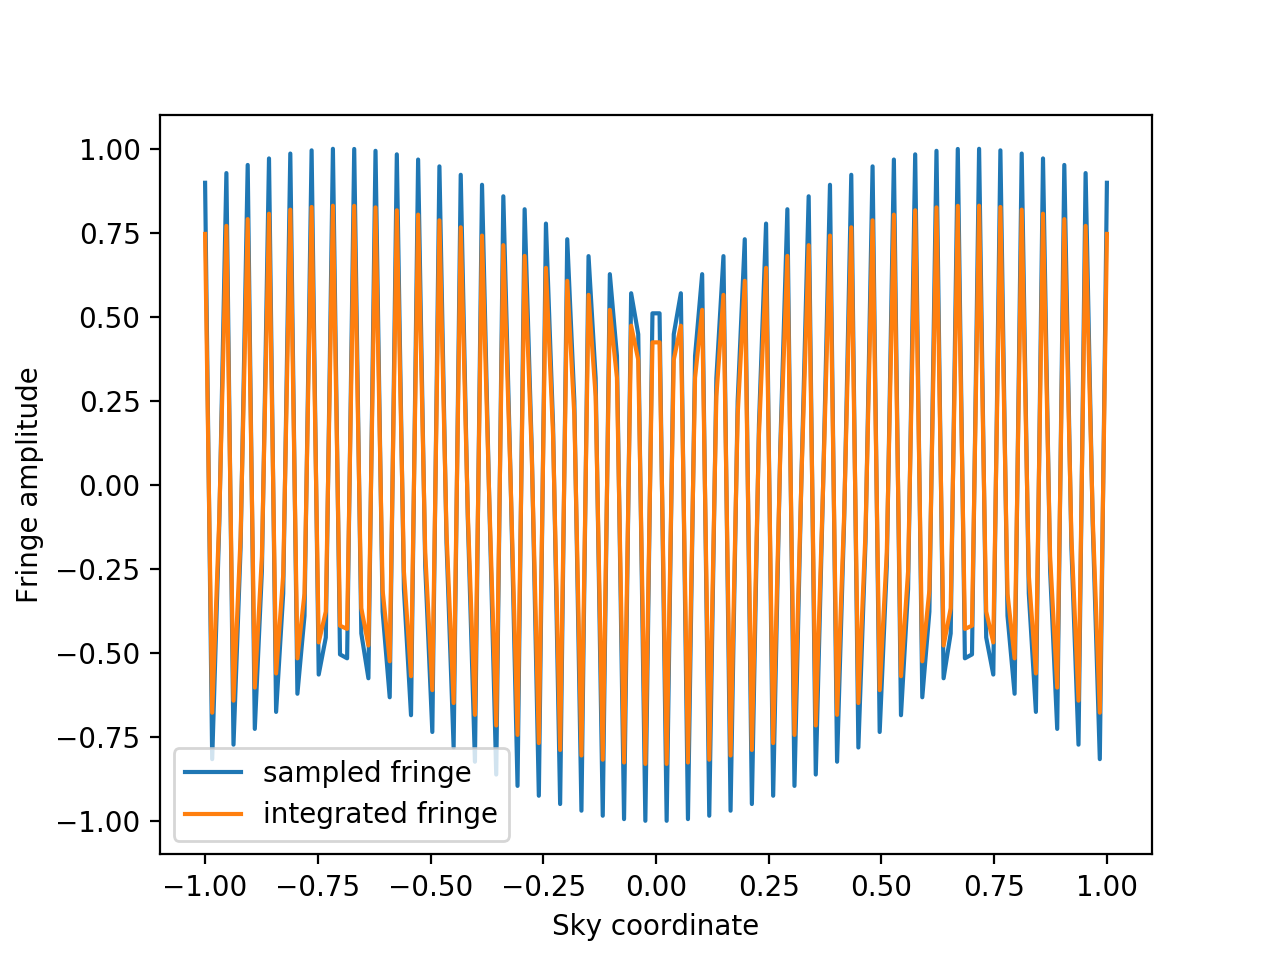

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [10]:
fq = freqs.flatten()[-1]
bl = antpos[0] - antpos[6]
fringe = np.exp(-2j*np.pi*xs*bl[0]*fq)
fringe_1 = np.exp(-2j*np.pi*(xs+dx/2)*bl[0]*fq)
fringe_2 = np.exp(-2j*np.pi*(xs-dx/2)*bl[0]*fq)
int_fringe = 1./(-2j*np.pi*bl[0]*fq) * (fringe_1 - fringe_2) / dx
plt.figure()
plt.plot(xs.flatten(), fringe.flatten(), label='sampled fringe')
plt.plot(xs.flatten(), int_fringe.flatten(), label='integrated fringe')
plt.xlabel('Sky coordinate')
plt.ylabel('Fringe amplitude')
plt.legend(loc='best')

In [11]:
bm = {
    'G': beam_gaussian(xs, freqs, chromatic=True),
    'g': beam_gaussian(xs, freqs, chromatic=False),
    'S': beam_sinc(xs, freqs, chromatic=True),
    's': beam_sinc(xs, freqs, chromatic=False),
}
vis = {}
for bm_key in bm.keys():
    for sky_key in Isky.keys():
        vis[bm_key + sky_key] = np.empty((NFREQS, NANTS, NANTS), dtype=np.complex64)
for ai,aj in baselines:
    blx,bly,blz = bl = antpos[ai] - antpos[aj]
    # Integrate fringe pattern to avoid aliasing for a sparsely sampled sky
    #fringe = np.exp(-2j*np.pi*xs*bl[0]*freqs) # took integral of this over a pixel
    fringe_1 = np.exp(-2j*np.pi*(xs+dx/2)*blx*freqs)
    fringe_2 = np.exp(-2j*np.pi*(xs-dx/2)*blx*freqs)
    fringe = 1./(-2j*np.pi*blx*freqs*dx) * (fringe_1 - fringe_2) / dx
    for k,v in vis.items():
        v[:,ai,aj] = np.sum(bm[k[0]] * fringe * Isky[k[1]], axis=0)
        v[:,aj,ai] = v[:,ai,aj].conj()

## Visibility spectra from multiple baselines, plotted versus $u$

<IPython.core.display.Javascript object>


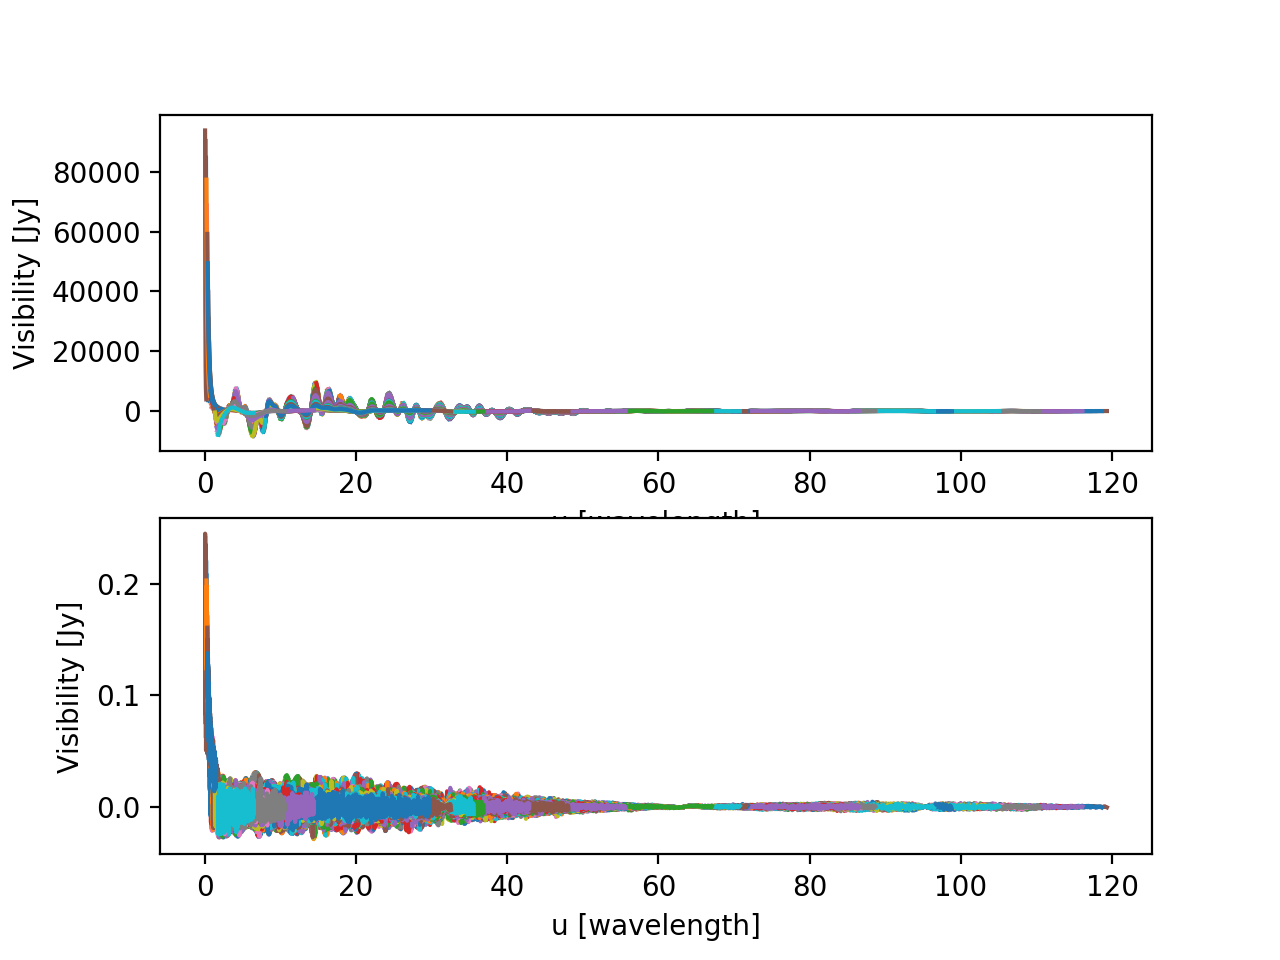

Text(0,0.5,'Visibility [Jy]')

In [12]:
freqs = freqs.flatten()
plt.figure()
plt.subplot(211)
for ai,aj in baselines:
    blx,bly,blz = bl = antpos[ai] - antpos[aj]
    us = blx * freqs
    plt.plot(us, vis['GF'][:,ai,aj])
plt.xlabel('u [wavelength]')
plt.ylabel('Visibility [Jy]')
plt.subplot(212)
for ai,aj in baselines:
    blx,bly,blz = bl = antpos[ai] - antpos[aj]
    us = blx * freqs
    plt.plot(us, vis['GE'][:,ai,aj])
plt.xlabel('u [wavelength]')
plt.ylabel('Visibility [Jy]')

## Interpolating visibilities to a fixed $u$

### Simulate visibilities on a fixed grid in $u$

In [13]:
u = 30
# Determine true visibility
# Integrate fringe pattern to avoid aliasing for a sparsely sampled sky
freqs.shape = (1,-1)
fringe_1 = np.exp(-2j*np.pi*(xs+dx/2)*u)
fringe_2 = np.exp(-2j*np.pi*(xs-dx/2)*u)
fringe = 1./(-2j*np.pi*u*dx) * (fringe_1 - fringe_2) / dx
# Simulate visibilites exactly at the specified $u$
V_u = {k: np.sum(bm[k[0]] * fringe * Isky[k[1]], axis=0) for k in vis.keys()}
true_cubic = {k: interp1d(freqs.flatten(), v, kind='cubic', assume_sorted=True) for k,v in V_u.items()}

<IPython.core.display.Javascript object>


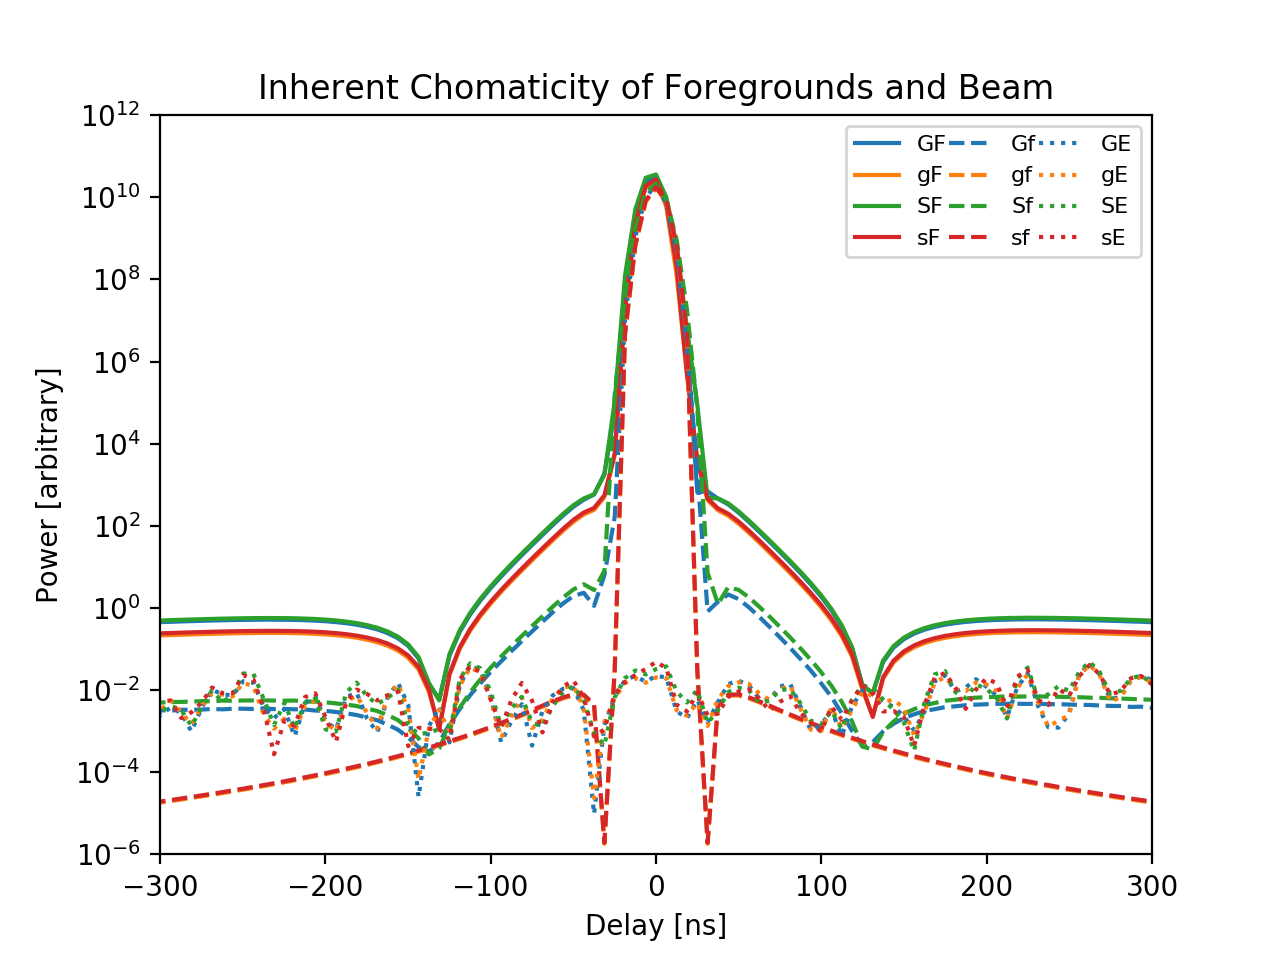

In [14]:
plt.figure()
ax = plt.gca()
window = aipy.dsp.gen_window(freqs.size, 'blackman-harris')
tau = np.fft.fftfreq(freqs.size, np.median(np.diff(freqs.flatten())))
for fg_type, linestyle in zip('FfE',('-','--',':')):
    for bm_type in 'GgSs':
        k = bm_type + fg_type
        dat = window * V_u[k].flatten()
        _dat = np.abs(np.fft.fft(dat))**2
        plt.semilogy(np.fft.fftshift(tau), np.fft.fftshift(_dat), linestyle, label=k)
    for i in range(6): ax._get_lines.get_next_color()
plt.xlim(-300,300)
plt.ylim(1e-6, 1e12)
plt.title('Inherent Chomaticity of Foregrounds and Beam')
plt.xlabel('Delay [ns]')
plt.ylabel('Power [arbitrary]')
plt.legend(ncol=3, columnspacing=.1, fontsize=8)

### Filter true visibilities

In [15]:
filter_widths = [10., 20., 40., 80., 160.]
wgts = np.ones_like(freqs.flatten())
df = np.median(np.diff(freqs.flatten()))
noise = np.random.normal(loc=0, scale=1e-5, size=freqs.size)
kwargs = {'filter_centers':[0.], 'filter_factors':[1e-9], 'filter_dimensions':[1]}
V_uf = {}
for k in V_u.keys():
    for w in filter_widths:
        kwargs['filter_half_widths'] = [w]
        V_uf[k+'_',w], info = linear_filter(V_u[k], wgts, df, **kwargs)
        V_uf[k+'N',w], info = linear_filter(V_u[k] + noise, wgts, df, **kwargs)
        V_uf[k+'E',w], info = linear_filter(V_u[k] + V_u[k[0]+'E'], wgts, df, **kwargs)

<IPython.core.display.Javascript object>


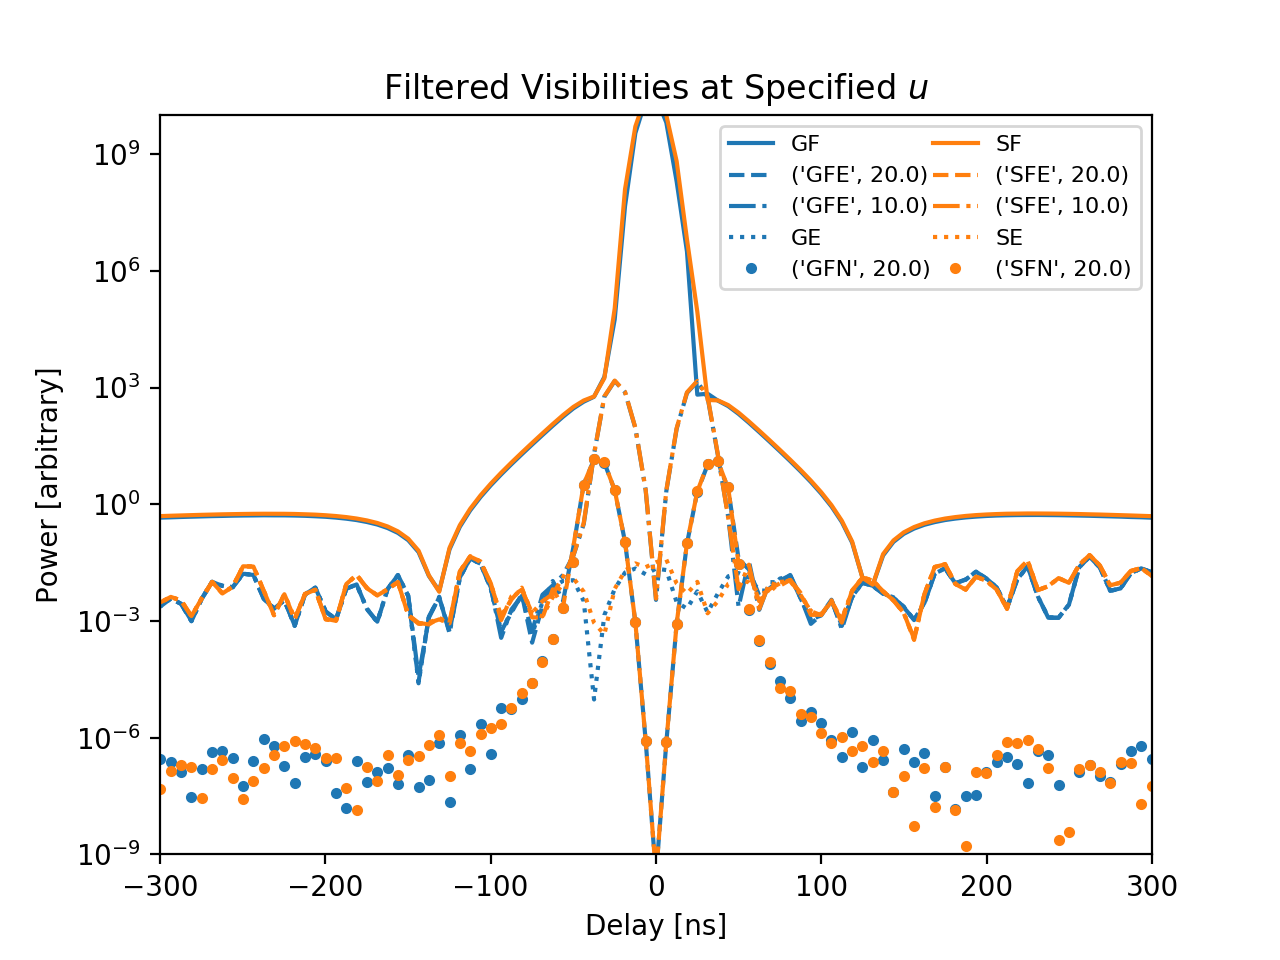

In [16]:
plt.figure()
ax = plt.gca()
window = aipy.dsp.gen_window(freqs.size, 'blackman-harris')
tau = np.fft.fftfreq(freqs.size, np.median(np.diff(freqs.flatten())))
for k in 'GS':
    keys = (k+'F', (k+'FE',20.), (k+'FE',10.), k+'E', (k+'FN',20.))
    lines = ('-','--','-.',':', '.')
    for k,lin in zip(keys,lines):
        if type(k) is str: dat = V_u[k]
        else: dat = V_uf[k]
        dat = window * dat.flatten()
        _dat = np.abs(np.fft.fft(dat))**2
        plt.semilogy(np.fft.fftshift(tau), np.fft.fftshift(_dat), lin, label=k)
        for i in range(9): ax._get_lines.get_next_color()
    ax._get_lines.get_next_color()
plt.xlim(-300,300)
plt.ylim(1e-9, 1e10)
plt.title('Filtered Visibilities at Specified $u$')
plt.xlabel('Delay [ns]')
plt.ylabel('Power [arbitrary]')
plt.legend(ncol=2, columnspacing=.1, fontsize=8)

The plot above seems to indicate that, if we had access to measurements of a given $u$ mode for all frequencies, we would be able to contain the foregrounds to low delay modes, even when we include the chromaticity of the the beam.

### Interpolate data to specified $u$

Now we need to see if we can get similar results interpolating chromatic visibilities to
a given $u$ from the visibilities handed us by an array.

In [17]:
FQ_RES = np.median(np.diff(freqs))
freqs = freqs.flatten()
_V_u = {'lin':{}, 'cub':{}}
for bm_fg, v in vis.items():
    for interp in _V_u.keys():
        _V_u[interp][bm_fg] = {}
    for ai,aj in baselines:
        blx,bly,blz = bl = antpos[ai] - antpos[aj]
        fq = u / blx # interpolate to u set above
        if fq < freqs[0] or fq > freqs[-1]: continue
        key = (fq, ai, aj)
        _V_u['cub'][bm_fg][key] = interp1d(freqs, vis[bm_fg][:,ai,aj], kind='cubic', assume_sorted=True)(fq)
        fq_px0 = np.floor((fq - freqs[0]) / FQ_RES).astype(np.int)
        fq_px1 = fq_px0 + 1
        d = (fq - freqs[0]) / FQ_RES - fq_px0
        _V_u['lin'][bm_fg][key] = (1-d) * vis[bm_fg][fq_px0,ai,aj] + d * vis[bm_fg][fq_px1,ai,aj]
keys = _V_u['lin'].values()[0].keys()
keys.sort()
vis_u_freqs = np.array([k[0] for k in keys])
vis_u = {}
for interp in _V_u.keys():
    vis_u[interp] = {bm_fg:[v[k] for k in keys] for bm_fg,v in _V_u[interp].items()}

<IPython.core.display.Javascript object>


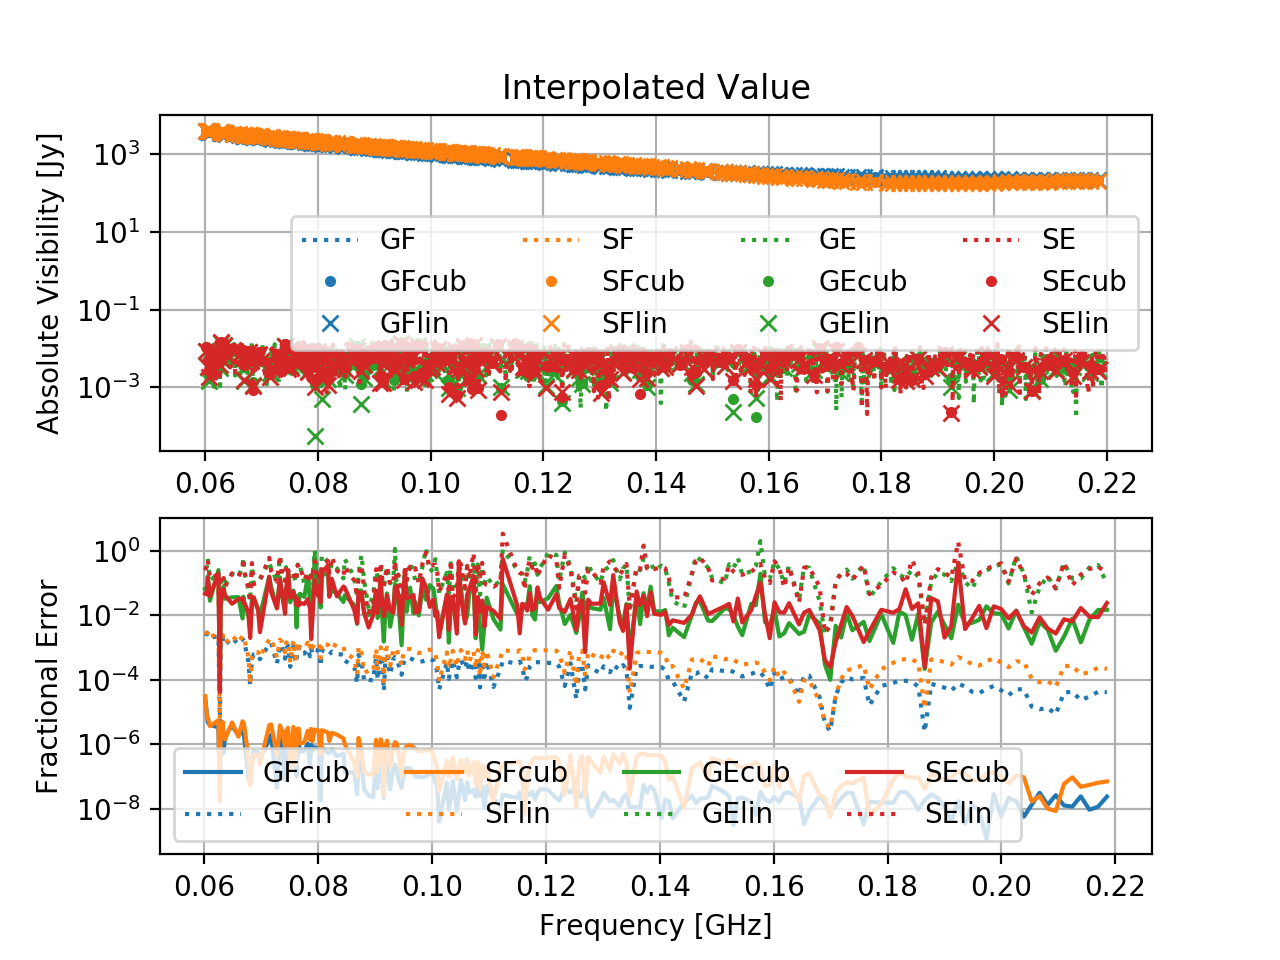

In [18]:
plt.figure()
ax = plt.subplot(211)
for k in ('GF','SF','GE','SE'):
    plt.semilogy(freqs, np.abs(true_cubic[k](freqs)), ':', label=k)
    for i in range(9): ax._get_lines.get_next_color()
    plt.semilogy(vis_u_freqs, np.abs(vis_u['cub'][k]), '.', label=k+'cub')
    for i in range(9): ax._get_lines.get_next_color()
    plt.semilogy(vis_u_freqs, np.abs(vis_u['lin'][k]), 'x', label=k+'lin')
plt.title('Interpolated Value')
plt.ylabel('Absolute Visibility [Jy]')
plt.legend(ncol=4)
plt.grid()

ax = plt.subplot(212)
for k in ('GF','SF','GE','SE'):
    Vtrue = true_cubic[k](vis_u_freqs)
    plt.semilogy(vis_u_freqs, np.abs(vis_u['cub'][k]/Vtrue - 1), '-', label=k+'cub')
    for i in range(9): ax._get_lines.get_next_color()
    plt.semilogy(vis_u_freqs, np.abs(vis_u['lin'][k]/Vtrue - 1), ':', label=k+'lin')
plt.xlabel('Frequency [GHz]')
plt.ylabel('Fractional Error')
plt.legend(ncol=4)
plt.grid()

The above plots show that it is possible to interpolate the sampled data of a (noiseless) baseline to the frequency corresponding to a particular $u$ mode with reasonable accuracy.  Linear interpolation has error associated with it which is mitigated with cubic interpolation.  If we need better interpolation, the delay basis would be a good candidate for further improvement, but to accurately reproduce EoR modes, it will need to include high delays.

### Filter interpolated samples

In [19]:
wgts_u = np.ones_like(vis_u_freqs.flatten())
noise_u = np.random.normal(loc=0, scale=1e-6, size=vis_u_freqs.size)
df_u = 1.
kwargs = {'filter_centers':[0.], 'filter_factors':[1e-9],
          'filter_dimensions':[1], 'user_frequencies':vis_u_freqs}
vis_uf = {}
for interp in vis_u.keys():
    vis_uf[interp] = {}
    for k,v in vis_u[interp].items():
        v = np.array(v)
        for w in filter_widths:
            kwargs['filter_half_widths'] = [w]
            vis_uf[interp][k+'_',w], info = linear_filter(v, wgts_u, df_u, **kwargs)
            vis_uf[interp][k+'N',w], info = linear_filter(v + noise_u, wgts_u, df_u, **kwargs)
            vis_uf[interp][k+'E',w], info = linear_filter(v + vis_u[interp][k[0]+'E'], wgts_u, df_u, **kwargs)

<IPython.core.display.Javascript object>


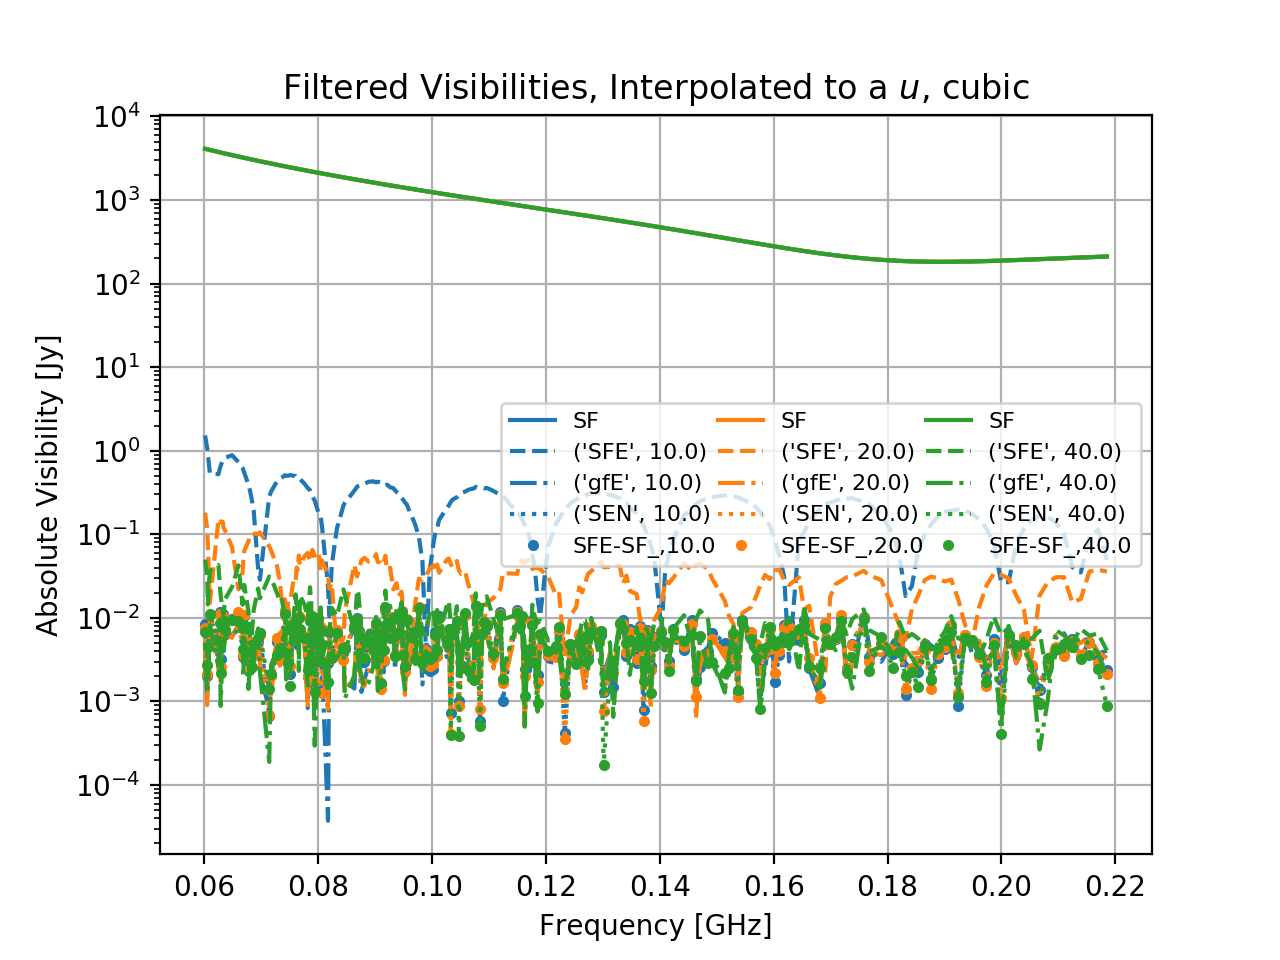

In [20]:
plt.figure()
ax = plt.gca()
for w in (10., 20., 40.):
    keys = ('SF', ('SFE',w), ('gfE',w), ('SEN',w))
    lines = ('-','--','-.',':', '.')
    for k,lin in zip(keys,lines):
        if type(k) is str: dat = vis_u['cub'][k]
        else: dat = vis_uf['cub'][k]
        plt.semilogy(vis_u_freqs, np.abs(dat), lin, label=k)
        for i in range(9): ax._get_lines.get_next_color()
    plt.semilogy(vis_u_freqs, np.abs(vis_uf['cub']['SFE',w] - vis_uf['cub']['SF_',w]), '.', label='SFE-SF_,'+str(w))
    #ax._get_lines.get_next_color()
plt.title('Filtered Visibilities, Interpolated to a $u$, cubic')
plt.xlabel('Frequency [GHz]')
plt.ylabel('Absolute Visibility [Jy]')
plt.legend(ncol=3, columnspacing=.1, fontsize=8)
plt.grid()

<IPython.core.display.Javascript object>


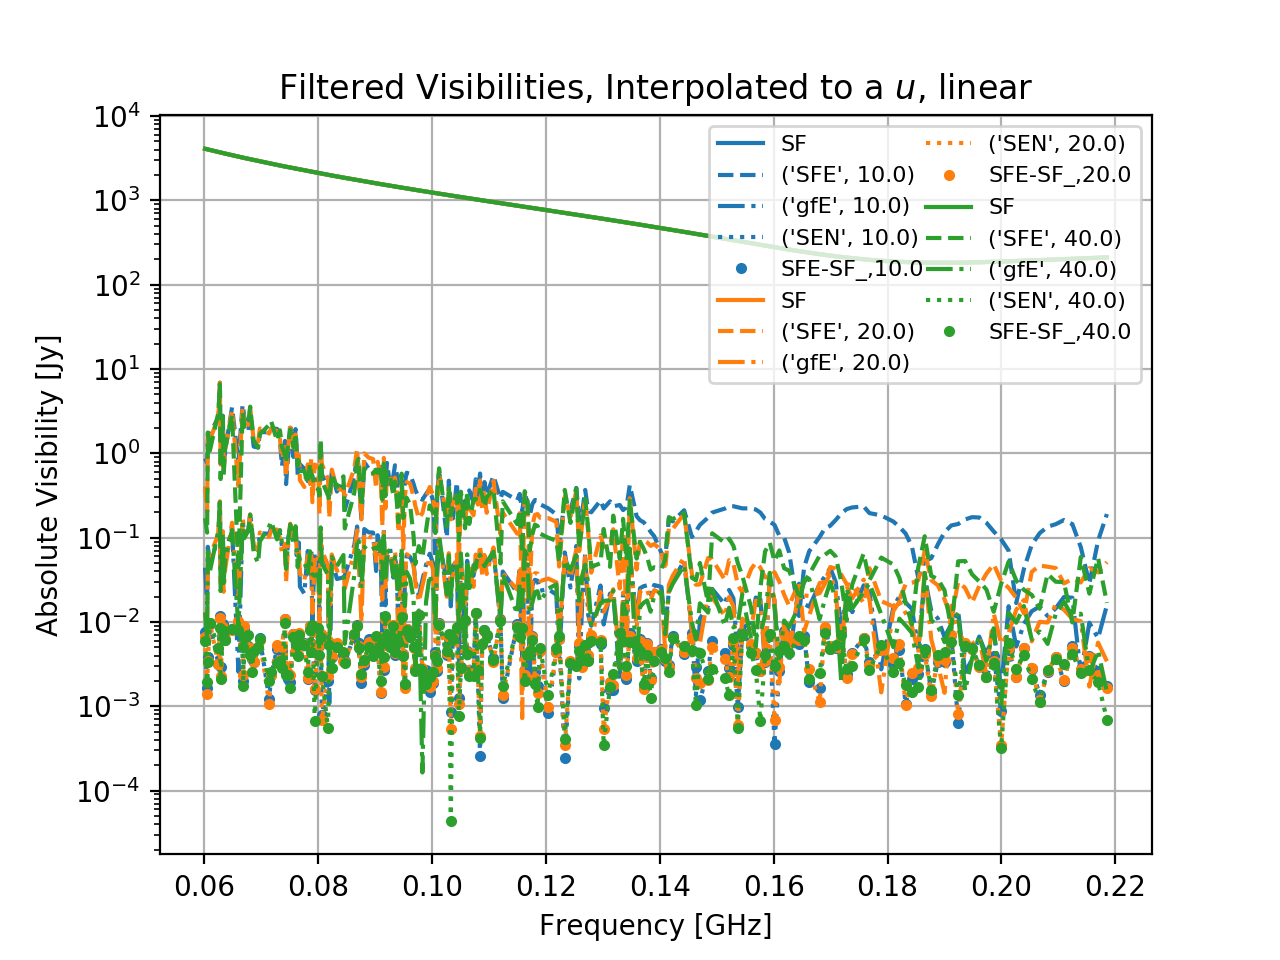

In [21]:
plt.figure()
ax = plt.gca()
for w in (10., 20., 40.):
    keys = ('SF', ('SFE',w), ('gfE',w), ('SEN',w))
    lines = ('-','--','-.',':', '.')
    for k,lin in zip(keys,lines):
        if type(k) is str: dat = vis_u['lin'][k]
        else: dat = vis_uf['lin'][k]
        plt.semilogy(vis_u_freqs, np.abs(dat), lin, label=k)
        for i in range(9): ax._get_lines.get_next_color()
    plt.semilogy(vis_u_freqs, np.abs(vis_uf['lin']['SFE',w] - vis_uf['lin']['SF_',w]), '.', label='SFE-SF_,'+str(w))
    #ax._get_lines.get_next_color()
plt.title('Filtered Visibilities, Interpolated to a $u$, linear')
plt.xlabel('Frequency [GHz]')
plt.ylabel('Absolute Visibility [Jy]')
plt.legend(ncol=2, columnspacing=.1, fontsize=8)
plt.grid()

The above plots illustrate that for sufficiently smooth foregrounds/beams (e.g. achromatic, gaussian = gfE), foregrounds can be filtered out to recover the EoR signal.  However, if the array sampling is too sparse (at higher frequencies, for example), these filters kill a lot of EoR signal. Worst case, they throw out as much foreground as EoR and the signal is inaccessible by filtering, although it may be recovered by subtracting off foregrounds.

In order to be able to effectively separate foregrounds from EoR, the array must deliver a certain density of sampling.  Inasmuch as foreground amplitude controls the amplitude of the residual, interpolation matters, but it is probably not the primary effect.

# Using Redundancy in $u$ to subtract foregrounds in baselines

In [22]:
u = 30
# Pick a good baseline to use
for ai,aj in baselines:
    blx,bly,blz = bl = antpos[ai] - antpos[aj]
    fq = u / blx # interpolate to u set above
    if fq < freqs[0] or fq > freqs[-1]: continue
    key = (fq, ai, aj)
    #print(key)
# For chosen baseline, find frequencies corresponding to u's that are heavily covered by other baselines
ai,aj = (16, 6) # Hits u=30 at 127 MHz
blx,bly,blz = bl = antpos[ai] - antpos[aj]
umin,umax = 27., 44. # this range manually selected from plot above to be region with ~200 baseline samples
chans = np.where(np.logical_and(umin < freqs * blx, freqs * blx < umax))
afreqs = freqs[chans]
print(afreqs.size)

460


Now for each frequency in this baseline that corresponds to a well-covered $u$,
gather all the other baselines that touch that $u$ (interpolating measured data
in frequency to hit the exact $u$), then interpolate the spectrum at this exact
$u$ to the frequency we chose for this baseline.

In [35]:
v_uf = {'SF':[], 'SFE':[], 'SE':[]}
for cnt,fq in enumerate(afreqs):
    if cnt % 20 == 0: print(cnt, fq)
    u = fq * blx
    _V_u = {'SF':{}, 'SFE':{}, 'SE':{}}
    # search all baselines for ones that contain this u
    for _ai,_aj in baselines:
        _blx,_bly,_blz = _bl = antpos[_ai] - antpos[_aj]
        _fq = u / _blx # interpolate to u set above
        if _fq < freqs[0] or _fq > freqs[-1]: continue
        key = (_fq, _ai, _aj)
        for bm_fg in v_uf.keys():
            dat = vis[bm_fg[:2]][:,_ai,_aj].copy()
            if len(bm_fg) == 3:
                dat += vis[bm_fg[0]+bm_fg[-1]][:,_ai,_aj]
            _V_u[bm_fg][key] = interp1d(freqs, dat, kind='cubic', assume_sorted=True)(_fq)
    keys = _V_u['SF'].keys()
    keys.sort()
    vis_u_freqs = np.array([k[0] for k in keys])
    fq_index = [i for i,k in enumerate(keys) if k[1:] == (ai,aj)][0]
    if cnt % 20 == 0: print(fq, vis_u_freqs.size, fq_index)
    # build spectrum for this exact u
    vis_u = {bm_fg:[v[k] for k in keys] for bm_fg,v in _V_u.items()}
    wgts_u = np.ones_like(vis_u_freqs.flatten())
    df_u = 1.
    kwargs = {'filter_centers':[0.], 'filter_factors':[1e-9],
              'filter_dimensions':[1], 'user_frequencies':vis_u_freqs}
    for k,v in vis_u.items():
        v = np.array(v)
        w = 40. # ns
        kwargs['filter_half_widths'] = [w]
        _v_uf, info = linear_filter(v, wgts_u, df_u, **kwargs)
        # invert the high-pass linear filter to get a smoothed spectrum.
        # this is necessary because otherwise v contains the original baseline
        # and we will just subtract that from itself to get zero.
        # XXX note, this can also happen if sampling is more sparse than the filter width
        v_uf[k].append((v - _v_uf)[fq_index])

0 0.11427174975562072
0.11427174975562072 210 112
20 0.11739980449657869
0.11739980449657869 209 114
40 0.12052785923753666
0.12052785923753666 208 117
60 0.12365591397849462
0.12365591397849462 208 120
80 0.12678396871945258
0.12678396871945258 209 124
100 0.12991202346041056
0.12991202346041056 207 126
120 0.13304007820136854
0.13304007820136854 206 128
140 0.1361681329423265
0.1361681329423265 205 131
160 0.13929618768328444
0.13929618768328444 204 133
180 0.14242424242424243
0.14242424242424243 200 133
200 0.1455522971652004
0.1455522971652004 197 133
220 0.14868035190615836
0.14868035190615836 194 133
240 0.1518084066471163
0.1518084066471163 190 133
260 0.1549364613880743
0.1549364613880743 187 133
280 0.15806451612903227
0.15806451612903227 185 133
300 0.16119257086999023
0.16119257086999023 183 133
320 0.16432062561094818
0.16432062561094818 179 133
340 0.16744868035190616
0.16744868035190616 177 133
360 0.17057673509286414
0.17057673509286414 174 133
380 0.1737047898338221
0.1

<IPython.core.display.Javascript object>


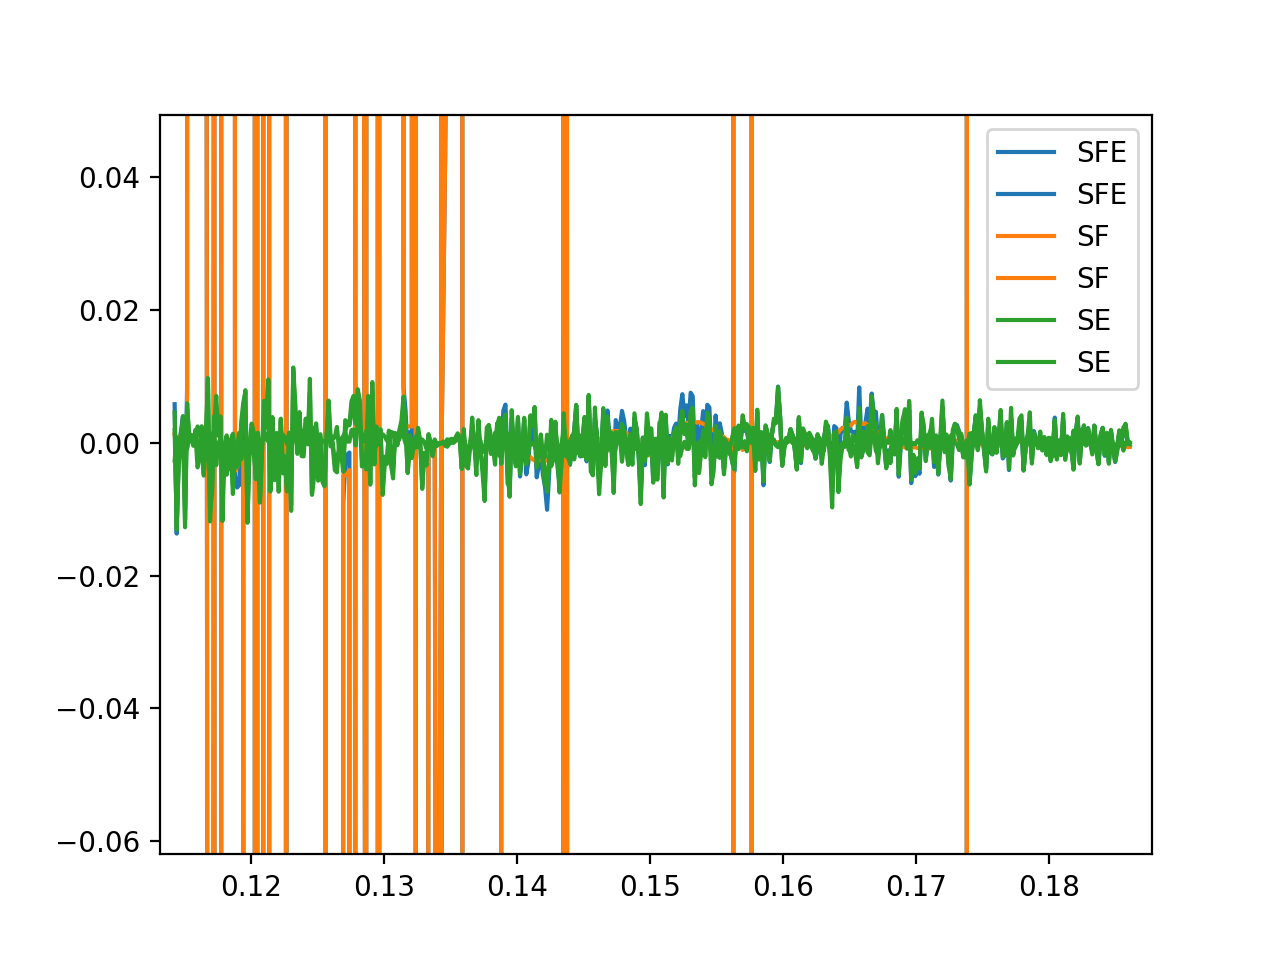

In [37]:
plt.figure()
ax = plt.gca()
ai,aj = (16, 6) # Hits u=30 at 127 MHz
for bm_fg,vmdl in v_uf.items():
    #if bm_fg == 'SF': continue
    v = vis[bm_fg[:2]][chans,ai,aj]
    if len(bm_fg) == 3:
        v += vis[bm_fg[0]+bm_fg[-1]][chans,ai,aj]
    v = v.flatten()
    vmdl = np.array(vmdl)
    if vmdl.size == 0: continue
    plt.plot(afreqs, v, label=bm_fg)
    for i in range(9): ax._get_lines.get_next_color()
    plt.plot(afreqs, vmdl, label=bm_fg)
    for i in range(9): ax._get_lines.get_next_color()
    plt.plot(afreqs, v-vmdl)
plt.legend()

The upshot of the plot above seems to be that interpolation across baselines using a 40 ns low-pass filter preserves the EoR signal in the measurements, provided that sampling is dense enough.  Near the lower end of the band, it looks like the extrapolation from nearby baselines breaks down a bit and we don't see full foreground supression.  Above about 135 MHz, the sampling gets more dense (and the baseline in question closer to the middle of the range, I'd guess), and the residuals drop to a level comparable with the injected EoR signal, although at a spectral scale that is easier to differentiate.

In principle, at least, it is possible to use data from nearby baselines to subtract foregrounds from an individual baseline at a level deep enough to permit delay-spectrum analysis within the wedge.  However, there are hints that this might only work when sampling is dense enough that a line-of-sight (wedge-less) transform was possible anyway.  It is not clear if this will work if baseline samples are sparse.

At the very least, it seems likely that the frequency coverage of baselines around the $u$ of the baseline in question should be finer than the scale of foreground variation, which for this simulation is around 40 ns.  That would imply a minimum sampling scale of 25 MHz. However, we seem to see breakdowns when we have sampling density far above this (~100 samples per 100 MHz coming to about 1 MHz sampling density).  I'm not sure why, though it is likely that this could be improved by using delay filtering to allow interpolations at one frequency to inform the model at nearby frequencies.

## Impose a bandpass on ideal simulated visibilities.

I think the next step is to build a linear solver for calibrating the bandpass to ensure that different baselines accessing the same $u$ mode have been calibrated to one another.  Based on the results above, linear interpolation is probably not sufficient.  We need to write down equations of the form:
\begin{equation}
V(\vec b, \nu) = \beta_\nu V(u)
\end{equation}
But given that V(u) is not the same at every frequency, we want the $\beta_\nu$ answers that produce the smoothest result.

In [25]:
#bandpass = np.polyval([-8, 4, -.75, 1], freqs)
bandpass = np.ones_like(freqs)
bandpass /= np.average(bandpass)
#plt.figure()
#plt.plot(freqs,bandpass)
#plt.show()

# Solving interpolating in $V$ and $g$

Looping over all (non-redundant) baselines, looping over discrete $u_k$ modes,
interpolate each $g(\nu)\cdot V_{ij}(\nu)$ to the exact frequency where $\nu = u_k / b$, so that the
baseline samples that $u_k$ mode exactly.

Set up a system of equations that discretely samples $g(\nu_i)$ and models the bandpass at $\nu$ as a linear interpolation of adjacent discrete samples of the bandpass, e.g.:
\begin{equation}
g(\nu)= f\cdot g(\nu_i) + (1-f)\cdot g(\nu_{i+1})
\end{equation}
for $f = (\nu_{i+1}-\nu)/\Delta\nu$.

## Generate System of Equations

In [26]:
#us = np.linspace(0, 1150, 2300)
#FQ_RES = freqs[1] - freqs[0]
#data = {}
#for ai,aj in baselines:
#    blx,bly,blz = bl = antpos[ai] - antpos[aj]
#    for k,u0 in enumerate(us):
#        fq = u0 / blx
#        if fq < freqs[0] or fq >= freqs[-1]: continue
#        fq_px0 = np.floor((fq - freqs[0]) / FQ_RES).astype(np.int)
#        fq_px1 = fq_px0 + 1
#        d = (fq - freqs[0]) / FQ_RES - fq_px0
#        cubic = scipy.interpolate.interp1d(freqs, bandpass * vis[:,ai,aj], kind='cubic', assume_sorted=True)
#        v = cubic(fq)
#        data['%f * g_%d * u_%d + %f * g_%d * u_%d' % (1-d, fq_px0, k, d, fq_px1, k)] = v

## Solve System of Equations (compute intense)

In [27]:
#sol0 = {'g_%d' % (i): 1. for i in range(freqs.size)}
#sol0.update({'u_%d' % (i): (20+0j) for i in range(us.size)})
#ls = linsolve.LinProductSolver(data, sol0=sol0)
#meta, sol = ls.solve_iteratively(conv_crit=1e-14, maxiter=500, verbose=True)

In [28]:
#print meta['conv_crit'], meta['iter'], meta['chisq']

## Compare, for a particular $u$, the data vs. model solution

In [29]:
#plt.figure()
#keys = [k for k in data.keys() if k.find('u_600 ') != -1]
#keys.sort(key=lambda k: int(k.split()[2][2:]))
#plt.plot([data[k] for k in keys], '.-')
#plt.plot([eval(k,sol) for k in keys], '.-')
#plt.show()

## Extract the Bandpass and $u$-modes as arrays

In [30]:
#px = np.array([int(k[2:]) for k in sol.keys() if k.startswith('u')])
#usol = np.zeros(us.shape, dtype=np.complex64)
#usol[px] = [sol[k] for k in sol.keys() if k.startswith('u')]
#px = np.array([int(k[2:]) for k in sol.keys() if k.startswith('g')])
#bpsol = np.zeros(freqs.size, dtype=np.complex64)
#bpsol[px] = [sol[k] for k in sol.keys() if k.startswith('g')]
#bpavg = np.average(bpsol)
## Set average bandpass to 1, solving a degeneracy between u and g
#bpsol /= bpavg
#usol *= bpavg

## Plot (true) visibilities and solution, plot unsmooth structure on bandpass

In [31]:
#plt.figure(figsize=(8,4))
#plt.subplot(121)
#for sep in baselines:
#    i,j = seps[sep]
#    u = (antpos[j][0] - antpos[i][0]) * freqs
#    plt.plot(u, vis[:,i,j], '.')
#plt.plot(us,usol)
#plt.subplot(122)
#p = np.polyfit(np.log10(freqs), np.log10(bpsol), deg=1)
#pbp = 10**np.polyval(p, np.log10(freqs))
#plt.plot(freqs, bpsol/pbp)
##plt.plot(freqs, bpsol)
##plt.plot(freqs, bandpass)
#plt.show()

In [32]:
#URES = us[1] - us[0]
#plt.figure()
#for sep in baselines:
#    ai,aj = seps[sep]
#    b = (antpos[aj][0] - antpos[ai][0])
#    u = b * freqs
#    u_px0 = np.floor(u / URES).astype(np.int)
#    ind = u_px0 < 2280
#    u_px0 = u_px0[ind]
#    u_px1 = u_px0 + 1
#    f = u[ind]/URES - u_px0
#    #f = np.where(usol[u_px0] == 0, 1, f)
#    #f = np.where(usol[u_px1] == 0, 0, f)
#    umdl = (1-f) * usol[u_px0] + f * usol[u_px1]
#    #plt.plot(u, bandpass * vis[:,0,i], '.')
#    #plt.plot(u, bpsol * umdl, '.')
#    plt.plot(u[ind], bandpass[ind] * vis[:,ai,aj][ind] - bpsol[ind] * umdl, '.')
#plt.plot(us,usol/1000)
#plt.show()

In [33]:
#plt.figure()
#u = 300.
#FQ_RES = freqs[1] - freqs[0]
#for sep in baselines:
#    i,j = seps[sep]
#    b = (antpos[j][0] - antpos[i][0])
#    fq = u / b
#    if fq < freqs[0] or fq > freqs[-1]: continue
#    cubic = scipy.interpolate.interp1d(freqs, vis[:,i,j], kind='cubic', assume_sorted=True)
#    fq_px0 = np.floor((fq - freqs[0]) / FQ_RES).astype(np.int)
#    fq_px1 = fq_px0 + 1
#    d = (fq - freqs[0]) / FQ_RES - fq_px0
#    v0 = (1-d) * vis[fq_px0,i,j] + d * vis[fq_px1,i,j]
#    #plt.plot([fq], v0 / 10**(np.polyval(p, fq)), 'r.')
#    plt.plot([fq], cubic(fq), 'r.')
#    plt.plot([fq], cubic(fq) / 10**(np.polyval(p, np.log10(fq))), 'b.')
#plt.show()

In [34]:
#u = 300.
#FQ_RES = freqs[1] - freqs[0]
#fq_list, V_list = [], []
#for sep in baselines:
#    i,j = seps[sep]
#    b = (antpos[j][0] - antpos[i][0])
#    fq = u / b
#    if fq < freqs[0] or fq > freqs[-1]: continue
#    cubic = scipy.interpolate.interp1d(freqs, vis[:,i,j], kind='cubic', assume_sorted=True)
#    fq_list.append(fq)
#    V_list.append(cubic(fq))
#fq_list = np.array(fq_list)
#V_list = np.array(V_list)
#plt.figure()
#plt.plot(fq_list, V_list, 'k.-')